<a href="https://colab.research.google.com/github/sydoky/Transfer-Learning-with-Tensorflow-Feature-Extraction-/blob/main/Transfer_Learning_with_Tensorflow(Feature_Extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Apr 21 14:28:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Getting great results with 10% of the data**

In [2]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2022-04-21 14:28:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2022-04-21 14:28:52 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
#How many imgaes in each folder 
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print("There are {} directories and {} images in {}".format(len(dirnames),len(filenames),(dirpath)))

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 10 directori

# **Preparing the data**

In [4]:
#setup data Inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224, 224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)

test_datagen=ImageDataGenerator(rescale=1/255.)
print("Training Images: ")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

print("Test Images: ")
test_data=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Test Images: 
Found 750 images belonging to 10 classes.


In [5]:
#Create Tensorboard Callback (comparing results of different models)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [8]:
def create_model(model_url, num_classes=10):
  
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model


# **Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer**

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [10]:
#Fit the model
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50V2")]) 
                                #callbacks to save and compare model results


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220421-142909
Epoch 1/5
24/24 [==============================] - 24s 400ms/step - loss: 2.1278 - accuracy: 0.2987 - val_loss: 1.2258 - val_accuracy: 0.6293
Epoch 2/5
24/24 [==============================] - 8s 336ms/step - loss: 0.9831 - accuracy: 0.7067 - val_loss: 0.7400 - val_accuracy: 0.7853
Epoch 3/5
24/24 [==============================] - 8s 345ms/step - loss: 0.6609 - accuracy: 0.8133 - val_loss: 0.5411 - val_accuracy: 0.8600
Epoch 4/5
24/24 [==============================] - 9s 390ms/step - loss: 0.5007 - accuracy: 0.8680 - val_loss: 0.4175 - val_accuracy: 0.8907
Epoch 5/5
24/24 [==============================] - 8s 329ms/step - loss: 0.4008 - accuracy: 0.9000 - val_loss: 0.3419 - val_accuracy: 0.9240


In [11]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

  #Plot Loss function
  
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

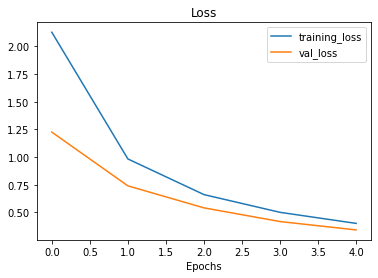

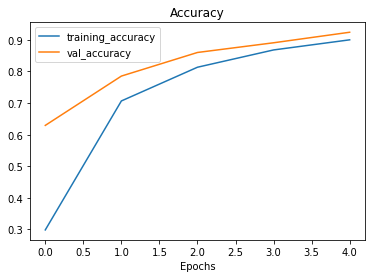

In [12]:
plot_loss_curves(resnet_history)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
#Create A model
efficientnet_model=create_model(model_url=efficientnet_url,
                             num_classes=train_data_10_percent.num_classes)

#Compile Efficient Model
efficientnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])


#Fit Efficient Model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetBO")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetBO/20220421-143018
Epoch 1/5
24/24 [==============================] - 20s 389ms/step - loss: 1.9129 - accuracy: 0.3947 - val_loss: 1.3083 - val_accuracy: 0.7387
Epoch 2/5
24/24 [==============================] - 8s 325ms/step - loss: 1.0637 - accuracy: 0.7800 - val_loss: 0.8429 - val_accuracy: 0.8320
Epoch 3/5
24/24 [==============================] - 9s 386ms/step - loss: 0.7596 - accuracy: 0.8440 - val_loss: 0.6433 - val_accuracy: 0.8720
Epoch 4/5
24/24 [==============================] - 8s 325ms/step - loss: 0.6054 - accuracy: 0.8693 - val_loss: 0.5328 - val_accuracy: 0.8933
Epoch 5/5
24/24 [==============================] - 8s 325ms/step - loss: 0.5101 - accuracy: 0.8987 - val_loss: 0.4555 - val_accuracy: 0.9133


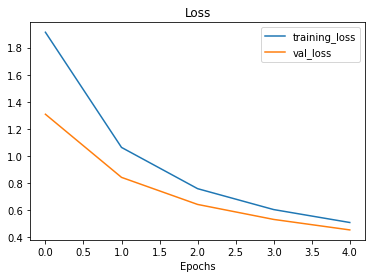

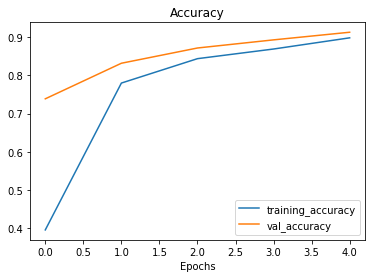

In [15]:
plot_loss_curves(efficientnet_history)